# MNIST Addition

This notebook shows an implementation of [MNIST Addition](https://arxiv.org/abs/1805.10872). In this task, pairs of MNIST handwritten images and their sums are given, alongwith a domain knowledge base containing information on how to perform addition operations. The task is to recognize the digits of handwritten images and accurately determine their sum.

Intuitively, we first use a machine learning model (learning part) to convert the input images to digits (we call them pseudo-labels), and then use the knowledge base (reasoning part) to calculate the sum of these digits. Since we do not have ground-truth of the digits, in abductive learning, the reasoning part will leverage domain knowledge and revise the initial digits yielded by the learning part through abductive reasoning. This process enables us to further update the machine learning model.

In [1]:
# Import necessary libraries and modules
import os.path as osp
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from examples.mnist_add.datasets import get_dataset
from examples.models.nn import LeNet5
from abl.learning import ABLModel, BasicNN
from abl.reasoning import KBBase, Reasoner
from abl.evaluation import ReasoningMetric, SymbolMetric
from abl.utils import ABLLogger, print_log
from abl.bridge import SimpleBridge

## Working with Data

First, we get the training and testing datasets:

In [2]:
train_data = get_dataset(train=True, get_pseudo_label=True)
test_data = get_dataset(train=False, get_pseudo_label=True)

Both `train_data` and `test_data` have the same structures: tuples with three components: X (list where each element is a pair of images), gt_pseudo_label (list where each element is a pair of digits) and Y (list where each element is the sum of each digit pair). The length and structures of datasets are illustrated as follows.

Note: ``gt_pseudo_label`` is only used to evaluate the performance of the learning part but not to train the model.

In [3]:
def describe_structure(lst):
    if not isinstance(lst, list):
        return type(lst).__name__ 
    return [describe_structure(item) for item in lst]

print(f"Both train_data and test_data consist of 3 components: X, gt_pseudo_label, Y")
print("\n")
train_X, train_gt_pseudo_label, train_Y = train_data
print(f"Length of X, gt_pseudo_label, Y in train_data: {len(train_X)}, {len(train_gt_pseudo_label)}, {len(train_Y)}")
test_X, test_gt_pseudo_label, test_Y = test_data
print(f"Length of X, gt_pseudo_label, Y in test_data: {len(test_X)}, {len(test_gt_pseudo_label)}, {len(test_Y)}")
print("\n")
structure_X = describe_structure(train_X[0])
structure_gt_pseudo_label = describe_structure(train_gt_pseudo_label[0])
structure_Y = describe_structure(train_Y[0])
print(f"Type of X: {type(train_X).__name__}, and type of each element in X: {structure_X}.")
print(f"Type of gt_pseudo_label: {type(train_gt_pseudo_label).__name__}, and type of each element in gt_pseudo_label: {structure_gt_pseudo_label}.")
print(f"Type of Y: {type(train_Y).__name__}, and type of each element in Y: {structure_Y}.")

Both train_data and test_data consist of 3 components: X, gt_pseudo_label, Y


Length of X, gt_pseudo_label, Y in train_data: 30000, 30000, 30000
Length of X, gt_pseudo_label, Y in test_data: 5000, 5000, 5000


Type of X: list, and type of each element in X: ['Tensor', 'Tensor'].
Type of gt_pseudo_label: list, and type of each element in gt_pseudo_label: ['int', 'int'].
Type of Y: list, and type of each element in Y: int.


The ith element of X, gt_pseudo_label, and Y together constitute the ith data example. As an illustration, in the first data example of the training set, we have:

X in the first data example (a pair of images):


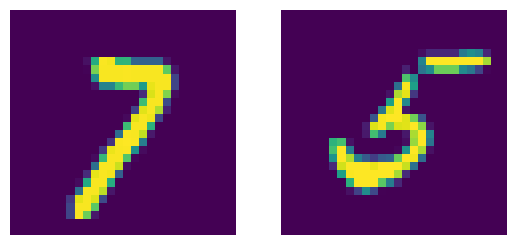

gt_pseudo_label in the first data example (a pair of ground truth pseudo-labels): 7, 5
Y in the first data example (their sum result): 12


In [4]:
first_X, first_gt_pseudo_label, first_Y = train_X[0], train_gt_pseudo_label[0], train_Y[0]
print(f"X in the first data example (a pair of images):")
plt.subplot(1,2,1)
plt.axis('off') 
plt.imshow(first_X[0].numpy().transpose(1, 2, 0))
plt.subplot(1,2,2)
plt.axis('off') 
plt.imshow(first_X[1].numpy().transpose(1, 2, 0))
plt.show()
print(f"gt_pseudo_label in the first data example (a pair of ground truth pseudo-labels): {first_gt_pseudo_label[0]}, {first_gt_pseudo_label[1]}")
print(f"Y in the first data example (their sum result): {first_Y}")

## Building the Learning Part

To build the learning part, we need to first build a machine learning base model. We use a simple [LeNet-5 neural network](https://en.wikipedia.org/wiki/LeNet), and encapsulate it within a `BasicNN` object to create the base model. `BasicNN` is a class that encapsulates a PyTorch model, transforming it into a base model with an sklearn-style interface. 

In [5]:
cls = LeNet5(num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cls.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

base_model = BasicNN(
    cls,
    loss_fn,
    optimizer,
    device,
    batch_size=32,
    num_epochs=1,
)

`BasicNN` offers methods like `predict` and `predict_prob`, which are used to predict the class index and the probabilities of each class for images. As shown below:

In [6]:
data_instances = [torch.randn(1, 28, 28).to(device) for _ in range(32)]
pred_idx = base_model.predict(X=data_instances)
print(f"Predicted class index for a batch of 32 instances: np.ndarray with shape {pred_idx.shape}")
pred_prob = base_model.predict_proba(X=data_instances)
print(f"Predicted class probabilities for a batch of 32 instances: np.ndarray with shape {pred_prob.shape}")

Predicted class index for a batch of 32 instances: np.ndarray with shape (32,)
Predicted class probabilities for a batch of 32 instances: np.ndarray with shape (32, 10)


However, the base model built above deals with instance-level data (i.e., individual images), and can not directly deal with example-level data (i.e., a pair of images). Therefore, we wrap the base model into `ABLModel`, which enables the learning part to train, test, and predict on example-level data.

In [7]:
model = ABLModel(base_model)

As an illustration, consider this example of training on example-level data using the `predict` method in `ABLModel`. In this process, the method accepts data examples as input and outputs the class labels and the probabilities of each class for all instances within these data examples.

In [8]:
from abl.structures import ListData
# ListData is a data structure provided by ABL-Package that can be used to organize data examples
data_example = ListData()
data_example.X = first_X
data_example.gt_pseudo_label = first_gt_pseudo_label
data_example.Y = first_Y

# Perform prediction on the first data examples
prediction_result = model.predict(data_example)
print(f"Predicted class labels for the first data example: np.array with shape {prediction_result['label'].shape}")
print(f"Predicted class probabilities for the first data example: np.array with shape {prediction_result['prob'].shape}")

Predicted class labels for the first data example: np.array with shape (2,)
Predicted class probabilities for the first data example: np.array with shape (2, 10)


## Building the Reasoning Part

In the reasoning part, we first build a knowledge base which contain information on how to perform addition operations. We build it by creating a subclass of `KBBase`. In the derived subclass, we initialize the `pseudo_label_list` parameter specifying list of possible pseudo-labels, and override the `logic_forward` function defining how to perform (deductive) reasoning.

In [9]:
class AddKB(KBBase):
    def __init__(self, pseudo_label_list=list(range(10))):
        super().__init__(pseudo_label_list)

    # Implement the deduction function
    def logic_forward(self, nums):
        return sum(nums)

kb = AddKB()

The knowledge base can perform logical reasoning (both deductive reasoning and abductive reasoning). Below is an example of performing (deductive) reasoning, and users can refer to [Documentation]() for details of abductive reasoning.

In [10]:
pseudo_label_example = [1, 2]
reasoning_result = kb.logic_forward(pseudo_label_example)
print(f"Reasoning result of pseudo-label example {pseudo_label_example} is {reasoning_result}.")

Reasoning result of pseudo-label example [1, 2] is 3.


Note: In addition to building a knowledge base based on `KBBase`, we can also establish a knowledge base with a ground KB using `GroundKB`, or a knowledge base implemented based on Prolog files using `PrologKB`. The corresponding code for these implementations can be found in the `main.py` file. Those interested are encouraged to examine it for further insights.

Then, we create a reasoner by instantiating the class ``Reasoner``. Due to the indeterminism of abductive reasoning, there could be multiple candidates compatible to the knowledge base. When this happens, reasoner can minimize inconsistencies between the knowledge base and pseudo-labels predicted by the learning part, and then return only one candidate that has the highest consistency.

In [11]:
reasoner = Reasoner(kb)

Note: During creating reasoner, the definition of "consistency" can be customized within the `dist_func` parameter. In the code above, we employ a consistency measurement based on confidence, which calculates the consistency between the data example and candidates based on the confidence derived from the predicted probability. In `main.py`, we provide options for utilizing other forms of consistency measurement.

Also, during process of inconsistency minimization, one can leverage [ZOOpt library](https://github.com/polixir/ZOOpt) for acceleration. Options for this are also available in `main.py`. Those interested are encouraged to explore these features.

## Building Evaluation Metrics

Next, we set up evaluation metrics. These metrics will be used to evaluate the model performance during training and testing. Specifically, we use `SymbolMetric` and `ReasoningMetric`, which are used to evaluate the accuracy of the machine learning model’s predictions and the accuracy of the final reasoning results, respectively.

In [12]:
metric_list = [SymbolMetric(prefix="mnist_add"), ReasoningMetric(kb=kb, prefix="mnist_add")]

## Bridge Learning and Reasoning

Now, the last step is to bridge the learning and reasoning part. We proceed this step by creating an instance of `SimpleBridge`.

In [13]:
bridge = SimpleBridge(model, reasoner, metric_list)

Perform training and testing by invoking the `train` and `test` methods of `SimpleBridge`.

In [ ]:
# Build logger
print_log("Abductive Learning on the MNIST Addition example.", logger="current")
log_dir = ABLLogger.get_current_instance().log_dir
weights_dir = osp.join(log_dir, "weights")

bridge.train(train_data, loops=5, segment_size=1/3, save_interval=1, save_dir=weights_dir)
bridge.test(test_data)